# 深入理解 diffusers

详细介绍 diffusers 的各个功能的调用方式。

## 使用 pipeline

pipeline 是最容易使用的方式。

是包括 model 和 scheduler 的端到端工具。

以下讲 diffusers 提供的 5 种 pipeline：

- 无条件生成图像
- 根据文本生成图像
- 根据图像生成图像
- 根据文本修复图像
- 根据文本深度生成图像？


In [ ]:
加载 pipeline

In [6]:
from diffusers import DiffusionPipeline

### 无条件生成图像

无条件图像生成生成的图像看起来像是来自模型训练数据的随机样本，因为去噪过程不受任何其他上下文（如文本或图像）的指导。

Loading pipeline components...:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

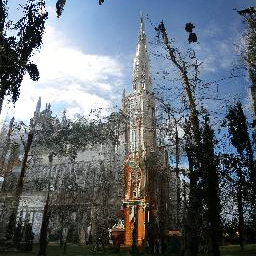

In [7]:
model_path="/models/ddpm-church-256"
generator = DiffusionPipeline.from_pretrained(model_path).to("cuda")

image = generator().images[0]
image

可以查看pipeline的配置。

In [12]:
generator

DDPMPipeline {
  "_class_name": "DDPMPipeline",
  "_diffusers_version": "0.24.0",
  "_name_or_path": "/models/ddpm-church-256",
  "scheduler": [
    "diffusers",
    "DDPMScheduler"
  ],
  "unet": [
    "diffusers",
    "UNet2DModel"
  ]
}

可以设置去噪点步骤数量，控制图像质量。

  0%|          | 0/20 [00:00<?, ?it/s]

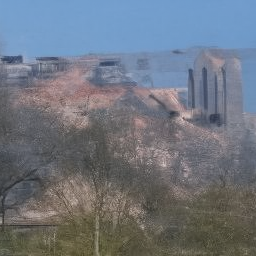

In [17]:
image = generator(num_inference_steps= 20 ).images[0]
image

### 文生图

从文本提示词描述生成图像。

迭代地消除噪声以构建图像。去噪过程由提示引导。

#### stable diffusion 1.5

In [ ]:
创建 pipeline，加载模型。

In [2]:
from diffusers import AutoPipelineForText2Image
import torch

model_path="/models/stable-diffusion-v1-5"
pipeline = AutoPipelineForText2Image.from_pretrained(
	model_path, torch_dtype=torch.float16, variant="fp16"
).to("cuda")

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.
/usr/local/lib/python3.10/dist-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(


通过提示词生成图像。

  0%|          | 0/50 [00:00<?, ?it/s]

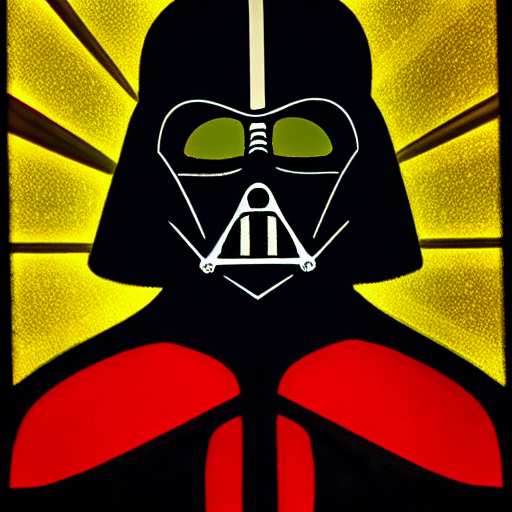

In [5]:
image = pipeline(
	"stained glass of darth vader, backlight, centered composition, masterpiece, photorealistic, 8k"
).images[0]
image

设置去噪点步骤数。

  0%|          | 0/5 [00:00<?, ?it/s]

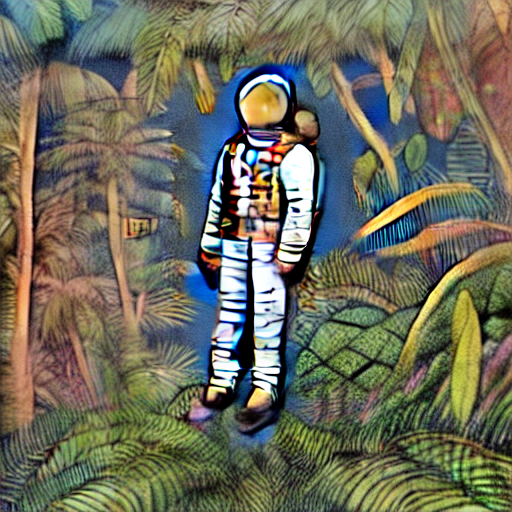

In [9]:
image = pipeline(
	"Astronaut in a jungle, cold color palette, muted colors, detailed",
    num_inference_steps=5
).images[0]
image

#### stabuel diffusion XL base 1.0

#### 高度和宽度

  0%|          | 0/50 [00:00<?, ?it/s]

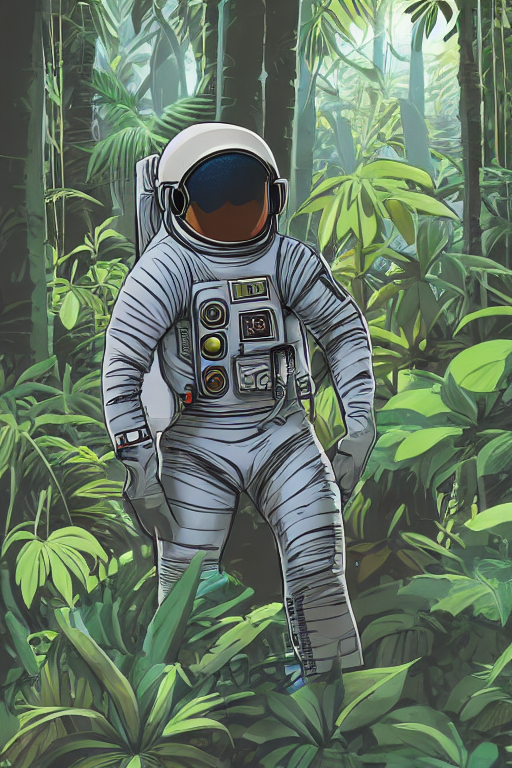

In [3]:
image = pipeline(
	"Astronaut in a jungle, cold color palette, muted colors, detailed, 8k", height=768, width=512
).images[0]
image

#### guidance scale

较低的值使模型具有“创造力”，可以生成与提示相关性更松散的图像。

  0%|          | 0/50 [00:00<?, ?it/s]

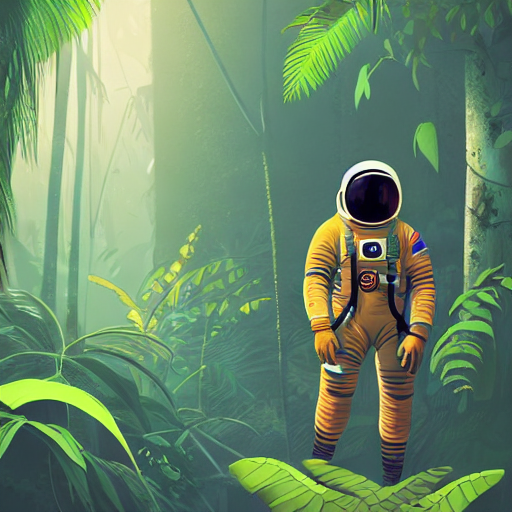

In [6]:
image = pipeline(
	"Astronaut in a jungle, cold color palette, muted colors, detailed, 8k", guidance_scale=10.5
).images[0]
image

#### 负面提示词

否定提示会引导模型远离您不希望模型生成的内容。

  0%|          | 0/50 [00:00<?, ?it/s]

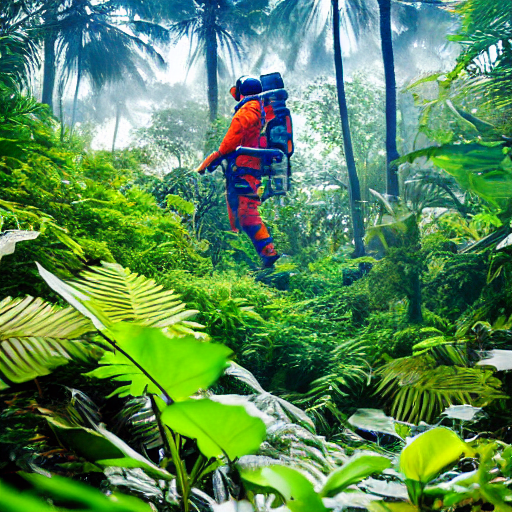

In [8]:
image = pipeline(
	prompt="Astronaut in a jungle, cold color palette, muted colors, detailed, 8k",
	negative_prompt="ugly,light dark, deformed, disfigured, poor details, bad, anatomy",
).images[0]
image

#### 手动设置 seed

默认是随机生成。下面代码每次执行都生成相同的图形。

  0%|          | 0/50 [00:00<?, ?it/s]

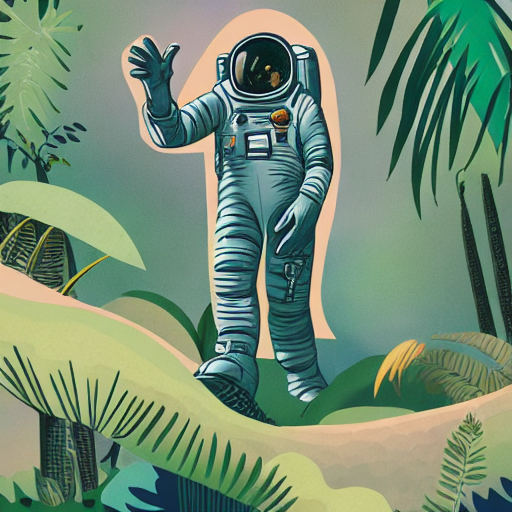

In [11]:
generator = torch.Generator(device="cuda").manual_seed(30)
image = pipeline(
	"Astronaut in a jungle, cold color palette, muted colors, detailed, 8k",
    guidance_scale=10.5,
	generator=generator,
).images[0]
image

#### 提示词的权重

建议使用 [Compel](https://github.com/damian0815/compel) 库来帮助您生成加权提示嵌入。

In [12]:
!pip install compel

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple


  0%|          | 0/20 [00:00<?, ?it/s]

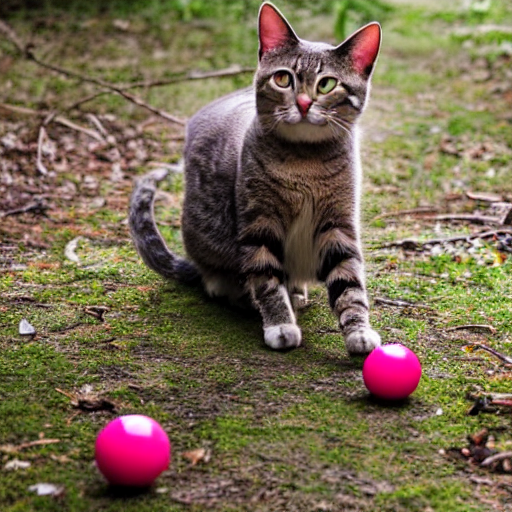

In [15]:
from compel import Compel

compel = Compel(tokenizer=pipeline.tokenizer, text_encoder=pipeline.text_encoder)

# upweight "ball"
prompt = "a cat playing with a ball++ in the forest"
conditioning = compel.build_conditioning_tensor(prompt)
# or: conditioning = compel([prompt])

# generate image
images = pipeline(prompt_embeds=conditioning, num_inference_steps=20).images
images[0]